In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip3 install python-mnist
# !wget https://github.com/sorki/python-mnist/blob/master/bin/mnist_get_data.sh
# !mnist_get_data.sh

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

import torch
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
import numpy as np
from scipy.spatial.distance import cdist
from mnist import MNIST
from IPython.display import clear_output

# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI/OPTAMI')
# sys.path.append('/content/drive/MyDrive/Documents/OPTAMI')
from OPTAMI import PrimalDualAccelerated
from run_pd_experiment import *

In [3]:
n = 784
m = int(np.sqrt(n))

In [4]:
# device = 'cuda:1'
device = 'cpu'

In [5]:
A_A_T_path = 'A_A_T.pkl'
if not os.path.exists(A_A_T_path):
    A_matrix = calculate_A_matrix(n).to(device)
    A_A_T = A_matrix @ A_matrix.T
    torch.save(A_A_T, A_A_T_path)
else:
    A_A_T = torch.load(A_A_T_path)

# Primal-Dual Tensor Method

In [6]:
eps = 0.02
# gamma = eps / (3 * np.log(n))
gamma = 0.35
image_index = 0

In [7]:
M_p = calculate_lipschitz_constant(n, gamma, p_order=3, A_A_T=A_A_T, device=device)

In [8]:
# def ot_softmax():
    # log_B = M_over_gamma + torch.outer(psi, torch.ones(n)) + torch.outer(eta, torch.ones(n))
    # max_log_B = log_B.max()
    # log_B_stable = log_B - max_log_B
    # B_stable = torch.exp(log_b_stable)
    
    # return gamma * (torch.log(B_stable.sum()) + max_log_B - lamb @ b)

In [8]:
M_matrix = calculate_M_matrix(m)
M_matrix = M_matrix.to(device)
M_matrix_over_gamma = M_matrix / gamma
ones = torch.ones(n, device=device, dtype=torch.double)
lamb = torch.zeros(n * 2, dtype=torch.double, requires_grad=True, device=device)
optimizer = PrimalDualAccelerated(
    [lamb],
    M_p=M_p,
    p_order=torch.tensor(3, device=device),
    eps=0.01,
    calculate_primal_var=lambda lamb: calculate_x(lamb, n, M_matrix_over_gamma, ones)
)

New

In [9]:
%%time
optimizer, i, cr_1, cr_2 = run_experiment(
    M_p,
    gamma, 
    eps, 
    image_index,
    optimizer=optimizer,
    max_steps=3,
    device=device
)

Step #0
cr_1: 7.882519551305478e-06 -> 7.882519551305478e-06
cr_2: 0.02381674410771223 -> 0.02381674410771223
tensor(2.3448e-07, dtype=torch.float64)
Step #1
cr_1: 7.882519551305478e-06 -> 0.22837325656871466
cr_2: 0.02381674410771223 -> 0.018617554429168723
tensor(3.3294e-06, dtype=torch.float64)
Step #2
cr_1: 7.882519551305478e-06 -> 0.41493026339533357
cr_2: 0.02381674410771223 -> 0.013939993657810679
tensor(1.3551e-05, dtype=torch.float64)


KeyboardInterrupt: 

Old

# Fast gradient method for dual function

In [63]:
eps = 0.02
# gamma = eps / (3 * np.log(n))
gamma = 0.35
image_index = 0

In [64]:
def fast_gradient_method(
    L, 
    M_matrix,
    primal_function, 
    dual_function, 
    primal_var_function,
    round_function,
    A_matrix,
    b,
    eps,
    eps_tilde,
    device='cpu'
):
    
    dual_var_next = torch.zeros(2 * n, requires_grad=True, dtype=torch.double, device=device)
    y_next = torch.zeros(2 * n, dtype=torch.double, device=device)
    z_next = torch.zeros(2 * n, dtype=torch.double, device=device)
    k = 0
    one_over_L = 1 / L
    alpha_next = one_over_L
    sum_of_y = y_next
    while True:
        y = y_next.detach().clone()
        z = z_next.detach().clone()
        tau = 2 / (k + 2)
        
        with torch.no_grad():
            dual_var_next = tau * z + (1 - tau ) * y
            dual_var_next.requires_grad_(True)
            # dual_var_next.add_(z, alpha=tau).add_(y, alpha=1 - tau)
        
        phi_next = dual_function(dual_var_next)
        grad_phi_next = torch.autograd.grad(phi_next, dual_var_next)
        y_next = dual_var_next.detach().clone() - one_over_L * grad_phi_next[0]
        
        z_next = z - alpha_next * grad_phi_next[0]
        
        N = k + 1
        
        y_tilde = 1 / (N * (N + 3)) * (sum_of_y + (N + 1) ** 2 * y_next)
        sum_of_y += y_next
        
#         primal_var = primal_var_function(dual_var_next)
        primal_var, _, _ = primal_var_function(dual_var_next)
        
        
        F_value = dual_function(y_tilde)
        g_value = primal_function(primal_var)
        cr_1 = torch.abs(F_value + g_value)
        cr_2 = (M_matrix * (round_function(primal_var) - primal_var)).sum()
#         cr_2 = torch.norm(A_matrix @ primal_var - b)
        if k == 0:
            init_cr_1 = cr_1
            init_cr_2 = cr_2
        # print(f'Step #{k}, cr_1={cr_1}, cr_2={cr_2}, phi={F_value}, f={g_value}', end='\n\n')
        clear_output(wait=True)
        print('\n'.join([
            f'Step #{k + 1}', 
            f'cr_1: {init_cr_1} -> {cr_1}',
            f'cr_2: {init_cr_2} -> {cr_2}'
        ]))
        
        if cr_1 <= eps and cr_2 <= eps_tilde:
            break
        
        alpha_next = (k + 2) * one_over_L / 2
        k += 1
        
    return F_value, g_value, primal_var

In [65]:
images, labels = load_data()

p_list = [34860, 31226, 239, 37372, 17390]
q_list = [45815, 35817, 43981, 54698, 49947]

# x_array = np.linspace(1 / 2e-2, 1 / 4e-4, 6)
# epslist = 1 / x_array
epsp = eps
p, q = mnist(epsp, p_list[image_index], q_list[image_index], images, n)
p_ref, q_ref = mnist(0, p_list[image_index], q_list[image_index], images, n)
p = torch.tensor(p, device=device).double()
q = torch.tensor(q, device=device).double()
p_ref = torch.tensor(p_ref, device=device).double()
q_ref = torch.tensor(q_ref, device=device).double()
b = torch.cat((p, q))

In [66]:
M_matrix = calculate_M_matrix(m).to(device)

In [67]:
M_1 = calculate_lipschitz_constant(n, gamma, p_order=1, A_A_T=A_A_T, device=device)

In [68]:
ones = torch.ones(n, device=device, dtype=torch.double)
primal_func = lambda x: f(x, M_matrix, gamma, device)
dual_func = lambda lamb: phi(lamb, n, gamma, M_matrix / gamma, ones, p, q)
primal_var_func = lambda lamb: calculate_x(lamb, n, M_matrix / gamma, ones)
round_func = lambda primal_var: B_round(primal_var, p_ref, q_ref, ones)

In [69]:
eps, gamma

(0.02, 0.35)

In [70]:
%%time
F_value, g_value, primal_var = fast_gradient_method(
    M_1, 
    M_matrix,
    primal_func, 
    dual_func, 
    primal_var_func, 
    round_func,
    A_matrix, 
    b, 
    eps, 
    eps, 
    device=device
)

Step #31127
cr_1: 3.3930945919635747e-07 -> 0.019999773680838828
cr_2: 0.02381691311786889 -> 0.0010953159373318522
CPU times: user 2min 32s, sys: 11.4 s, total: 2min 43s
Wall time: 2min 34s


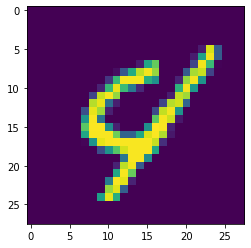

In [80]:
u = (primal_var.T @ ones).cpu().detach().view(28, 28)
plt.imshow(u)

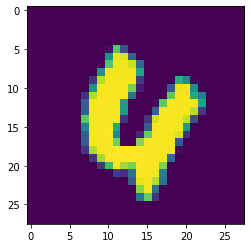

In [86]:
v = (primal_var @ ones).cpu().detach().view(28, 28)
plt.imshow(v)

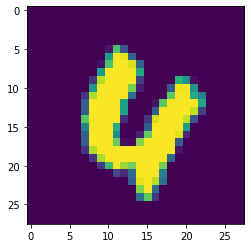

In [84]:
plt.imshow(p_ref.reshape(28, 28).cpu())

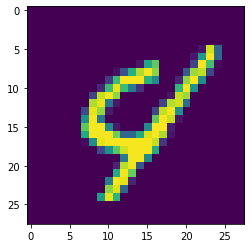

In [85]:
plt.imshow(q_ref.reshape(28, 28).cpu())

In [19]:
np.arange(4).reshape(2, 2).dot(np.ones(4).reshape(2, 2))

array([[1., 1.],
       [5., 5.]])

In [19]:
np.arange(4).reshape(2, 2).dot(np.ones(4).reshape(2, 2))

array([[1., 1.],
       [5., 5.]])

In [20]:
torch.arange(4).reshape(2, 2).dot(torch.ones(4).reshape(2, 2))

RuntimeError: 1D tensors expected, but got 2D and 2D tensors

In [26]:
(foo.dot(ones.cpu())).shape

RuntimeError: 1D tensors expected, but got 2D and 1D tensors

# TEST 

In [45]:
from mnist import MNIST
import numpy as np
from scipy.spatial.distance import cdist
import math
#https://pypi.org/project/python-mnist
mndata = MNIST('./data/')
images, labels = mndata.load_training()
%matplotlib inline
import matplotlib.pyplot as plt
import copy
from numpy import linalg
import time

l = len(images)
n = len(images[0])
m = int(np.sqrt(n))

# def mnist(eps, p, q):
#     p, q = np.float64(images[p]), np.float64(images[q])
#     p, q = p / sum(p), q / sum(q)
    
#     p = (1 - eps / 8) * p + eps / (8 * n)
#     q = (1 - eps / 8) * q + eps / (8 * n)
    
#     return p, q

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

C = np.arange(m)
C = cartesian_product(C, C)
C = cdist(C, C)
C /= np.max(C)
C.max()

1.0

In [46]:
one = np.ones(n, np.float64)
I = np.ones([n,n], np.float64)
def f_true(x):
    return (C * x).sum()

def B_round(x):
    r = p_ref / x.dot(one)
    r[r>1] = 1.
    F = np.diag(r).dot(x)
    c = q_ref / (x.T).dot(one)
    c[c>1] = 1.
    F = F.dot(np.diag(c))
    err_r = p_ref - F.dot(one)
    err_c = q_ref - (F.T).dot(one)
    return F + np.outer(err_r, err_c) / abs(err_r).sum()

In [47]:
C.shape

(784, 784)

In [94]:
def phi_(gamma, lamu):
    A = (-C/gamma + np.outer(lamu[:n], one) + np.outer(one, lamu[n:]))
    a = A.max()
    A-=a
    s = a+np.log(np.exp(A).sum())
    return gamma*(-lamu[:n].dot(p) - lamu[n:].dot(q) + s)

def f_(gamma, x):
    y = (x.reshape(-1)).copy()
    y[x.reshape(-1) == 0.] = 1.
    
    y = y.reshape(n, -1)
    return (C * x).sum() + gamma * (x * np.log(y)).sum()

In [124]:
def apd(x0, L):
    betta = 0.
    alpha = 0.
    primal_var = 0.*torch.ones([n, n], dtype=torch.float64)
    z = torch.zeros(2*n, dtype=torch.float64)
    z_new = torch.zeros(2*n, dtype=torch.float64)
    eta = torch.zeros(2*n, dtype=torch.float64)
    eta_new  = torch.zeros(2*n, dtype=torch.float64)
    grad_phi_new = torch.zeros(2*n, dtype=torch.float64)
    one = torch.tensor(one)
    
    # f = lambda x: phi_(gamma, x)
    # f_primal = lambda x: f_(gamma, x)
    f = lambda x: phi(x, n, gamma, M_matrix / gamma, torch.tensor(ones), p, q)
    f_primal = lambda x: f(x, M_matrix, gamma)
    
    k=0
    start_time = time.perf_counter()
    while True:
        # L = L / 2
        # while True:
        alpha_new = (1 + torch.sqrt(4*L*betta + 1)) / 2 / L
        betta_new = betta + alpha_new
        tau = alpha_new / betta_new
        lamu_new = tau * z + (1 - tau) * eta

        logB = (K + torch.outer(lamu_new[:n], one) + torch.outer(one, lamu_new[n:]))
        max_logB =logB.max()
        logB_stable = logB - max_logB

        B_stable = torch.exp(logB_stable)
        u_hat_stable, v_hat_stable = B_stable.dot(one), B_stable.T.dot(one)

        Bs_stable = u_hat_stable.sum()

        phi_new = gamma*(-lamu_new[:n].dot(p) - lamu_new[n:].dot(q) + torch.log(Bs_stable) + max_logB)
        grad_phi_new = gamma*torch.cat((-p + u_hat_stable/Bs_stable, -q + v_hat_stable/Bs_stable),0)


        z_new = z - alpha_new * grad_phi_new
        eta_new = tau * z_new + (1-tau) * eta

        phi_eta = f(eta_new)

            # if phi_eta <= phi_new + grad_phi_new.dot(eta_new - lamu_new) + L * ((eta_new - lamu_new)**2).sum() / 2:
        alpha, betta = alpha_new, betta_new
        z = z_new.copy()
        eta = eta_new.copy()
            #     break    
            # L = L * 2
        primal_var = tau * B_stable/Bs_stable + (1 - tau) * primal_var
        
        cr_1 = abs(f_primal(primal_var) + phi_eta)
        cr_2 = (C * (B_round(primal_var) - primal_var)).sum()
        if k == 0:
            init_cr_1 = cr_1
            init_cr_2 = cr_2

        clear_output(wait=True)
        print('\n'.join([
            f'Step #{k + 1}', 
            f'cr_1: {init_cr_1} -> {cr_1}',
            f'cr_2: {init_cr_2} -> {cr_2}'
        ]))
        if cr_2 <= eps/6 and cr_1 <= eps/6:
            return time.perf_counter() - start_time
        
        k=k+1

In [125]:
x_array = torch.linspace(1 / 2e-2, 1 / 4e-4, 6)
epslist = 1 / x_array

In [126]:
epslist

tensor([0.0200, 0.0019, 0.0010, 0.0007, 0.0005, 0.0004])

In [127]:
# if not os.path.isfile('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy'):
# i=0
# for eps in epslist:
k = 0
x0 = torch.zeros(2 * n, dtype=torch.float64)
epsp = epslist[0] / 8
p,q = mnist(epsp, p_list[k], q_list[k], images, n)
p_ref, q_ref = mnist(0, p_list[k], q_list[k], images, n)
gamma=eps/3/torch.log(torch.tensor(n))
K=-C/gamma
y_array[i] = apd(x0, M_1)
# i-=-1
    # np.save('/content/drive/My Drive/colab/'+'!e_'+'apd_'+str(k)+'.npy', y_array)
# print('apd_', k, ' - done', y_array)

UnboundLocalError: local variable 'one' referenced before assignment

In [45]:
foo = [torch.ones(5, requires_grad=True)]

In [42]:
type(foo)

list

In [36]:
bar = foo.norm()

In [37]:
grads = torch.autograd.grad(bar, foo)

In [43]:
grads

(tensor([0.4472, 0.4472, 0.4472, 0.4472, 0.4472]),)

In [40]:
optimizer.param_groups[0]['params']

[tensor([-0.0011, -0.0012, -0.0013,  ..., -0.0013, -0.0012, -0.0011],
        device='cuda:1', dtype=torch.float64, requires_grad=True)]

In [46]:
foo + grads

TypeError: can only concatenate list (not "tuple") to list